In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA, PCA
from sklearn.datasets import make_circles
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from ipywidgets import interactive, interact, fixed, widgets
import time

# Equation d'advection-diffusion

L'équation de la chaleur en une dimension spatiale est donnée par :
$$\frac{\partial u}{\partial t} + c\frac{\partial u}{\partial x} = \alpha \frac{\partial^2 u}{\partial x^2}$$
où $\alpha $ représente le coefficient de diffusion et $c$ la vitesse de convection.

La condition initiale est choisie comme une fonction gaussienne :

$$u(x,0) = A e^{-\frac{(x-x_0)^2}{2\sigma^2}}$$

où $\sigma$ est l'écart-type de la distribution initiale.

Simulons cela numériquement :

In [2]:
# Paramètres de simulation
L = 20.0       # Longueur du domaine
Nx = 200       # Nombre de points spatiaux
x = np.linspace(0, L, Nx)
dx = L / (Nx - 1)
c = 1.0        # Vitesse d'advection
nu = 0.05       # Coefficient de diffusion
dt = 0.01      # Pas de temps
T = 1.5        # Temps final
Nt = int(T / dt)  # Nombre de pas de temps

# Condition initiale
u = np.exp(-((x - L/4)**2) / 0.5)

# Matrice pour stocker la solution
U = np.zeros((Nx, Nt))
U[:, 0] = u

# Solution de l'équation d'advection-diffusion par différences finies
for n in range(1, Nt):
    U[1:-1, n] = U[1:-1, n-1] - c * dt / dx * (U[1:-1, n-1] - U[:-2, n-1]) + \
                 nu * dt / dx**2 * (U[2:, n-1] - 2 * U[1:-1, n-1] + U[:-2, n-1])
    U[0, n] = U[-1, n] = 0  # Conditions aux limites

## DMD
On applique l'algorithme DMD du cours et on propage en temps les mode DMD pour simuler notre système

In [4]:
# matrices de données X et X'
X = U[:, :-1]
X_prime = U[:, 1:]

# SVD sur X
U_svd, Sigma, Vt = np.linalg.svd(X, full_matrices=False)
V = Vt.T # attention np.linalg.svd retoure V^T et pas V

# Réduction de rang pour la SVD
r = 10  # Nombre de modes à conserver
U_r = U_svd[:, :r]
Sigma_r = np.diag(Sigma[:r])
inv_Sigma_r = np.diag(1/Sigma[:r])
V_r = V[:, :r]

# Calcul de K_tilde
K_tilde = U_r.T @ X_prime @ V_r @ inv_Sigma_r

# Valeurs propres et vecteurs propres de A_tilde
eigvals, Q = np.linalg.eig(K_tilde)

# Modes DMD
Phi = X_prime @ V_r @ inv_Sigma_r @ Q

# Calcul des amplitudes b des modes DMD pour correspondre à la condition initiale
b = np.linalg.pinv(Phi) @ U[:, 0]

# Dynamique temporelle DMD
Nt_ROM = int(Nt * 2.5)
t_dynamics = np.zeros((r, Nt_ROM), dtype=complex)

# Calculer la dynamique temporelle pour chaque mode
for t in range(Nt_ROM):
    t_dynamics[:, t] = b * (eigvals**t)

# Reconstruction des données
DMD_reconstructed = Phi @ t_dynamics


# Fonction pour visualiser les resultats
def plot_solution(n):
    plt.plot(x, DMD_reconstructed.real[:,n], label='DMD')
    try:
        plt.plot(x[::4], U[::4,n], 'r.', label='FOM')
    except:
        pass
    
    plt.xlabel("x")
    plt.ylabel("u")
    plt.ylim([-0.1,1.2])
    plt.title("t = %.1f"%(dt*n))
    plt.legend()
    plt.show()

# Création d'un widget interactif pour jouer avec gamma et le nombre de composantes
w = widgets.IntSlider(value=0, min=0, max=Nt_ROM-1)
interactive_plot = interactive(plot_solution, n=w)
interactive_plot




interactive(children=(IntSlider(value=0, description='n', max=374), Output()), _dom_classes=('widget-interact'…

## DMD vs POD pour l'analyse de données

In [5]:

# Paramètres
T = 10  # Temps final
dt = 0.01  # Pas de temps
N = int(T / dt)  # Nombre de pas de temps
t = np.linspace(0, T, N+1)  # Vecteur temps

# Fonctions gaussiennes
def gaussian(x, mu, sigma):
    return np.exp(-((x - mu) / sigma)**2 / 2)

# Génération des données
x = np.linspace(-5, 5, 100)  # Axe spatial
f1 = (gaussian(x, -1, 1) * np.exp(-0.5 * t)[:, np.newaxis]).T  # Première gaussienne décroissante
f2 = (gaussian(x, 1, 1) * np.exp(-0.1 * t)[:, np.newaxis]).T  # Deuxième gaussienne décroissante plus lentement
data = f1 + f2

# Fonction pour visualiser les resultats
def plot_evol(n):
    plt.plot(x,  f1[:, n], label="contribution 1")
    plt.plot(x,  f2[:, n], label="contribution 2")
    plt.plot(x,  data[:, n], label="solution")
    plt.xlabel("x")
    plt.ylabel("u")
    plt.ylim([-0.1,1.8])
    plt.title("t = %.1f"%(dt*n))
    plt.show()

# Création d'un widget interactif pour jouer avec gamma et le nombre de composantes
w = widgets.IntSlider(value=0, min=0, max=N-1)
interactive_plot = interactive(plot_evol, n=w)
interactive_plot



interactive(children=(IntSlider(value=0, description='n', max=999), Output()), _dom_classes=('widget-interact'…

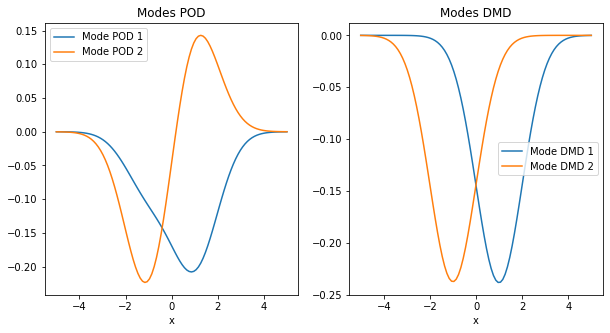

In [7]:
# Application de la POD
U, S, Vh = np.linalg.svd(data)
modes_pod = U[:, :2]

# Application de la DMD

# matrices de données X et X'
X = data[:, :-1]
X_prime = data[:, 1:]

# SVD sur X
U_svd, Sigma, Vt = np.linalg.svd(X, full_matrices=False)
V = Vt.T # attention np.linalg.svd retoure V^T et pas V

# Réduction de rang pour la SVD
r = 2  # Nombre de modes à conserver
U_r = U_svd[:, :r]
Sigma_r = np.diag(Sigma[:r])
inv_Sigma_r = np.diag(1/Sigma[:r])
V_r = V[:, :r]

# Calcul de K_tilde
K_tilde = U_r.T @ X_prime @ V_r @ inv_Sigma_r

# Valeurs propres et vecteurs propres de A_tilde
eigvals, Q = np.linalg.eig(K_tilde)

# Modes DMD
Phi = X_prime @ V_r @ inv_Sigma_r @ Q


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
for i in range(2):
    plt.plot(x, modes_pod[:, i], label=f'Mode POD {i+1}')
plt.title('Modes POD')
plt.xlabel('x')
plt.legend()

plt.subplot(1, 2, 2)
for i in range(2):
    plt.plot(x, Phi[:, i], label=f'Mode DMD {i+1}')
plt.title('Modes DMD')
plt.xlabel('x')
plt.legend()
plt.show()


## Choix des observables

On considère une serie temporelle venant d'un système dynamique inconnue

In [8]:
# Il s'agit du code qui génère nos données mais on suppose qu'on ne connait pas les équations ci-dessous

# Paramètres
T = 5  # Temps final
dt = 0.01  # Pas de temps
N = int(T / dt)  # Nombre de pas de temps
t = np.linspace(0, T, N+1)  # Vecteur temps

# Fonction de dynamique du pendule non linéaire avec frottement
def pendulum_dynamics(theta, theta_dot, f):
    theta_ddot = -np.sin(theta) - f * theta_dot
    return theta_ddot

# Résolution de l'équation différentielle du pendule avec la méthode d'Euler
def solve_pendulum(f):
    theta = np.zeros(N+1)
    theta_dot = np.zeros(N+1)
    theta[0] = 0.1  # Angle initial
    theta_dot[0] = 0  # Vitesse angulaire initiale

    for i in range(N):
        theta_ddot = pendulum_dynamics(theta[i], theta_dot[i], f)
        theta_dot[i+1] = theta_dot[i] + theta_ddot * dt
        theta[i+1] = theta[i] + theta_dot[i+1] * dt

    return theta, theta_dot



on applique la DMD naivement sur la série temporelle

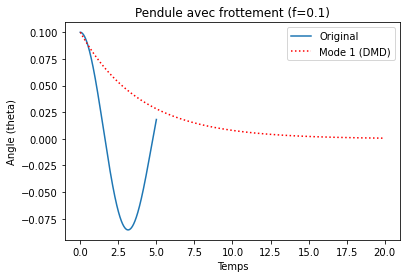

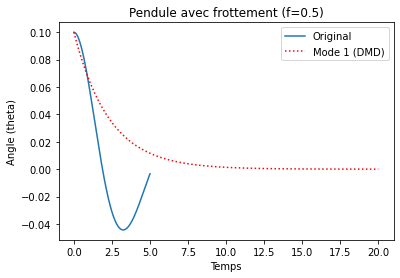

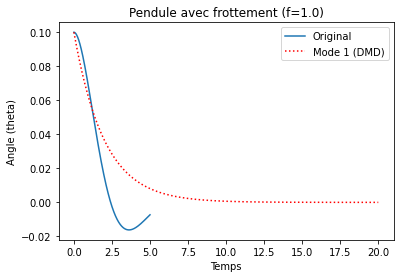

In [9]:
# Simulation du pendule avec différents coefficients de frottement
f_values = [0.1, 0.5, 1.0]
r = 1  # Nombre de modes à conserver
T_dmd = 20  # Temps final pour le modele DMD

N_dmd = int(T_dmd  / dt)  # Nombre de pas de temps
t_dmd  = np.linspace(0, T_dmd , N_dmd)  # Vecteur temps

# Application de la DMD pour chaque simulation
for f in f_values:
    # Résolution du pendule
    theta, theta_dot = solve_pendulum(f)

    # Construction de la matrice des snapshots
    X = theta[:-1].reshape(1,-1)
    X_prime = theta[1:].reshape(1,-1)
    
    # SVD sur X
    U_svd, Sigma, Vt = np.linalg.svd(X, full_matrices=False)
    V = Vt.T # attention np.linalg.svd retoure V^T et pas V

    # Réduction de rang pour la SVD
    U_r = U_svd[:, :r]
    Sigma_r = np.diag(Sigma[:r])
    inv_Sigma_r = np.diag(1/Sigma[:r])
    V_r = V[:, :r]

    # Calcul de K_tilde
    K_tilde = U_r.T @ X_prime @ V_r @ inv_Sigma_r
    
    # Valeurs propres et vecteurs propres de A_tilde
    eigvals, Q = np.linalg.eig(K_tilde)

    # Modes DMD
    Phi = X_prime @ V_r @ inv_Sigma_r @ Q

    # Calcul des amplitudes b des modes DMD pour correspondre à la condition initiale
    b = np.linalg.pinv(Phi) @ X[:,0]
    
    # Dynamique temporelle DMD
    t_dynamics = np.zeros((r, N_dmd), dtype=complex)

    # Calculer la dynamique temporelle pour chaque mode
    for i in range(N_dmd):
        t_dynamics[:, i] = b * (eigvals**i)

    # Reconstruction des données
    DMD_reconstructed = Phi @ t_dynamics

    plt.figure()
    plt.plot(t, theta, label='Original')
    plt.plot(t_dmd, DMD_reconstructed[0,:].real, 'r:', label='Mode 1 (DMD)')
    plt.title(f'Pendule avec frottement (f={f})')
    plt.xlabel('Temps')
    plt.ylabel('Angle (theta)')
    plt.legend()
    plt.show()

On applique la DMD sur l'état $(\theta, \dot{\theta})$

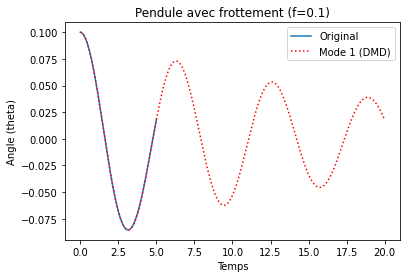

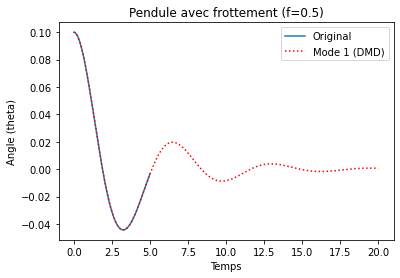

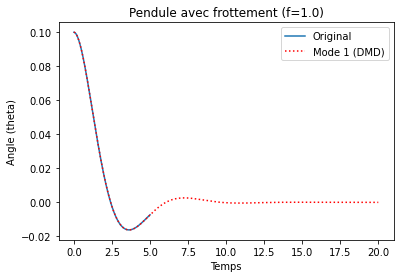

In [10]:
# Simulation du pendule avec différents coefficients de frottement
f_values = [0.1, 0.5, 1.0]
r = 2  # Nombre de modes à conserver
T_dmd = 20  # Temps final pour le modele DMD


N_dmd = int(T_dmd  / dt)  # Nombre de pas de temps
t_dmd  = np.linspace(0, T_dmd , N_dmd)  # Vecteur temps


# Application de la DMD pour chaque simulation
for f in f_values:
    # Résolution du pendule
    theta, theta_dot = solve_pendulum(f)

    # Construction de la matrice des snapshots
    X = np.vstack((theta[:-1], theta_dot[:-1]))
    X_prime = np.vstack((theta[1:], theta_dot[1:]))
    
    # SVD sur X
    U_svd, Sigma, Vt = np.linalg.svd(X, full_matrices=False)
    V = Vt.T # attention np.linalg.svd retoure V^T et pas V

    # Réduction de rang pour la SVD
    U_r = U_svd[:, :r]
    Sigma_r = np.diag(Sigma[:r])
    inv_Sigma_r = np.diag(1/Sigma[:r])
    V_r = V[:, :r]

    # Calcul de K_tilde
    K_tilde = U_r.T @ X_prime @ V_r @ inv_Sigma_r
    
    # Valeurs propres et vecteurs propres de A_tilde
    eigvals, Q = np.linalg.eig(K_tilde)

    # Modes DMD
    Phi = X_prime @ V_r @ inv_Sigma_r @ Q

    # Calcul des amplitudes b des modes DMD pour correspondre à la condition initiale
    b = np.linalg.pinv(Phi) @ X[:,0]
    
    # Dynamique temporelle DMD
    t_dynamics = np.zeros((r, N_dmd), dtype=complex)

    # Calculer la dynamique temporelle pour chaque mode
    for i in range(N_dmd):
        t_dynamics[:, i] = b * (eigvals**i)

    # Reconstruction des données
    DMD_reconstructed = Phi @ t_dynamics

    plt.figure()
    plt.plot(t, theta, label='Original')
    plt.plot(t_dmd, DMD_reconstructed[0,:].real, 'r:', label='Mode 1 (DMD)')
    plt.title(f'Pendule avec frottement (f={f})')
    plt.xlabel('Temps')
    plt.ylabel('Angle (theta)')
    plt.legend()
    plt.show()

La même chose mais avec des observables retardés en temps

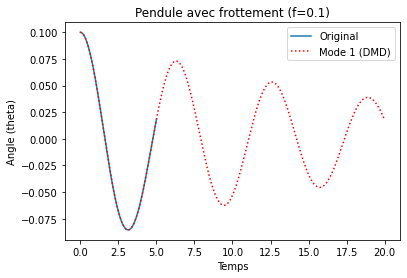

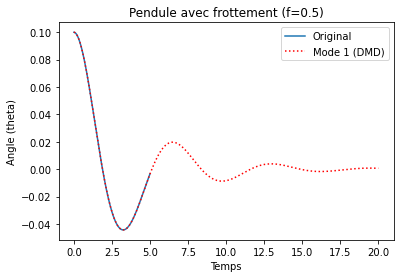

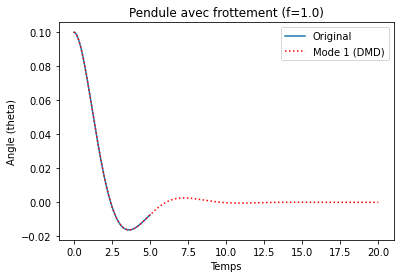

In [11]:
# Simulation du pendule avec différents coefficients de frottement
f_values = [0.1, 0.5, 1.0]
r = 2  # Nombre de modes à conserver
T_dmd = 20  # Temps final pour le modele DMD


N_dmd = int(T_dmd  / dt)  # Nombre de pas de temps
t_dmd  = np.linspace(0, T_dmd , N_dmd)  # Vecteur temps


# Application de la DMD pour chaque simulation
for f in f_values:
    # Résolution du pendule
    theta, theta_dot = solve_pendulum(f)

    # Construction de la matrice des snapshots
    X = np.vstack((theta[1:-1], theta[0:-2]))
    X_prime = np.vstack((theta[2:], theta[1:-1]))

    # SVD sur X
    U_svd, Sigma, Vt = np.linalg.svd(X, full_matrices=False)
    V = Vt.T # attention np.linalg.svd retoure V^T et pas V

    # Réduction de rang pour la SVD
    U_r = U_svd[:, :r]
    Sigma_r = np.diag(Sigma[:r])
    inv_Sigma_r = np.diag(1/Sigma[:r])
    V_r = V[:, :r]

    # Calcul de K_tilde
    K_tilde = U_r.T @ X_prime @ V_r @ inv_Sigma_r
    
    # Valeurs propres et vecteurs propres de A_tilde
    eigvals, Q = np.linalg.eig(K_tilde)

    # Modes DMD
    Phi = X_prime @ V_r @ inv_Sigma_r @ Q

    # Calcul des amplitudes b des modes DMD pour correspondre à la condition initiale
    b = np.linalg.pinv(Phi) @ X[:,0]
    
    # Dynamique temporelle DMD
    t_dynamics = np.zeros((r, N_dmd), dtype=complex)

    # Calculer la dynamique temporelle pour chaque mode
    for i in range(N_dmd):
        t_dynamics[:, i] = b * (eigvals**i)

    # Reconstruction des données
    DMD_reconstructed = Phi @ t_dynamics

    plt.figure()
    plt.plot(t, theta, label='Original')
    plt.plot(t_dmd, DMD_reconstructed[-1,:].real, 'r:', label='Mode 1 (DMD)')
    plt.title(f'Pendule avec frottement (f={f})')
    plt.xlabel('Temps')
    plt.ylabel('Angle (theta)')
    plt.legend()
    plt.show()

# Identification de système

In [112]:
def lorenz_system(t, state, sigma, rho, beta):
    x, y, z = state
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

# Paramètres du système de Lorenz
sigma, rho, beta = 10, 28, 8/3

# Conditions initiales et configuration de l'intégration
N_lorentz = 7000
initial_state = [1.0, 1.0, 1.0]
t_span = (0, 15)  # Intégrer de t=0 à t=2
t_eval = np.linspace(t_span[0], t_span[1], N_lorentz)  # Points de temps où la solution est évaluée

# Résolution du système de Lorenz
sol = solve_ivp(lorenz_system, t_span, initial_state, args=(sigma, rho, beta), t_eval=t_eval, method='RK45')

# Fonction pour visualiser les resultats
def plot_traj(n):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(sol.y[0][:n], sol.y[1][:n], sol.y[2][:n], color='b', alpha=0.7, linewidth=0.7)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Trajectoires du système de Lorenz')
    ax.set_xlim([-20,20])
    ax.set_ylim([-25,30])
    ax.set_zlim([0,50])
    plt.show()

# Création d'un widget interactif pour jouer avec gamma et le nombre de composantes
w = widgets.IntSlider(value=0, min=1, max=N_lorentz-1)
interactive_plot = interactive(plot_traj, n=w)
interactive_plot


interactive(children=(IntSlider(value=1, description='n', max=6999, min=1), Output()), _dom_classes=('widget-i…

In [113]:
def create_features(data):
    """ Crée des termes non-linéaires (polynomiaux) pour la régression. """
    x, y, z = data
    return np.vstack([x, y, z, x*y, y*z, x*z, x*x, y*y, z*z, x**3, y**3, z**3, x*y*z, np.sin(x), np.sin(y), np.sin(z), np.cos(x), np.cos(y), np.cos(z)]).T

# Création des caractéristiques et dérivées
X = create_features(sol.y)

# Calcul des dérivées numériques simples
X_dot = np.gradient(sol.y.T, axis=0, edge_order=2) / np.gradient(sol.t, edge_order=2)[:, None]

# calcul des equations par moindre carrés
models = [np.linalg.pinv(X) @ X_dot[:, i] for i in range(X_dot.shape[1])]

# Affichage des coefficients pour chaque variable
for i, model in enumerate(models):
    print(f"Équation pour la variable {i+1}:")
    print(" + ".join(f"{coef:.2f}*{name}" for coef, name in zip(model, ['x', 'y', 'z', 'xy', 'yz', 'xz', 'x^2', 'y^2', 'z^2', 'x^3', 'y^3', 'z^3', 'xyz', 'sin(x)', 'sin(y)', 'sin(z)', 'cos(x)', 'cos(y)', 'sin(z)']) if abs(coef) > 5e-2))

Équation pour la variable 1:
-9.95*x + 9.97*y
Équation pour la variable 2:
28.28*x + -1.02*y + -1.01*xz + 0.07*sin(y) + 0.12*cos(y) + -0.08*sin(z)
Équation pour la variable 3:
-2.69*z + 1.00*xy + 0.06*sin(x)


In [117]:
# En utilisant LASSO
models = [Lasso(alpha=0.01, max_iter=200000, fit_intercept=True, tol=1e-4).fit(X, X_dot[:, i]) for i in range(X_dot.shape[1])]

# Affichage des coefficients pour chaque variable
for i, model in enumerate(models):
    print(f"Équation pour la variable {i+1}:")
    print(" + ".join(f"{coef:.2f}*{name}" for coef, name in zip(model.coef_, ['x', 'y', 'z', 'xy', 'yz', 'xz', 'x^2', 'y^2', 'z^2', 'x^3', 'y^3', 'z^3', 'xyz', 'sin(x)', 'sin(y)', 'sin(z)']) if abs(coef) > 5e-2))

Équation pour la variable 1:
-9.61*x + 9.82*y
Équation pour la variable 2:
27.94*x + -0.85*y + -1.00*xz
Équation pour la variable 3:
-2.57*z + 1.00*xy


## Visualisation pour comprendre l'optimisation L1

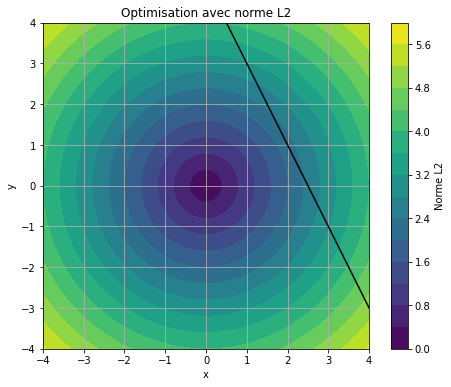

In [109]:
import numpy as np
import matplotlib.pyplot as plt

# Fonction à optimiser
def f(x, y):
    return y + 2*x - 5

# Définir l'espace 2D
x = np.linspace(-4, 4, 400)
y = np.linspace(-4, 4, 400)
y_opt = -2*x+5
X, Y = np.meshgrid(x, y)

# Calcul de la fonction
Z = f(X, Y)

# Calcul de la norme L2
L2_norm = np.sqrt(X**2 + Y**2)

# Plot de la fonction
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, L2_norm, levels=15, cmap='viridis')  # Cercles avec colormap viridis
plt.plot(x,y_opt, 'k')
# Configuration du plot
plt.xlabel('x')
plt.ylabel('y')
plt.title('Optimisation avec norme L2')
plt.colorbar(label='Norme L2')
plt.grid(True)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


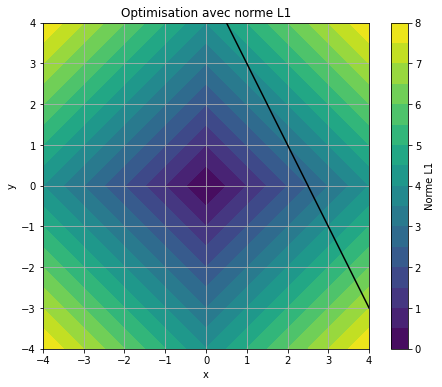

In [110]:
# Calcul de la norme L1
L1_norm = np.abs(X) + np.abs(Y)

# Plot de la fonction
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, L1_norm, levels=15, cmap='viridis')  # Cercles avec colormap viridis
plt.plot(x,y_opt, 'k')
# Configuration du plot
plt.xlabel('x')
plt.ylabel('y')
plt.title('Optimisation avec norme L1')
plt.colorbar(label='Norme L1')
plt.grid(True)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
